In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import yfinance as yf
import pandas as pd

# 1. Define your professional "Resume Set"
tickers = ['AAPL', 'NVDA', 'JPM', 'XOM', 'KO', '^GSPC'] # Tech, Finance, Energy, Consumer, S&P 500

# 2. Create a local directory for data
os.makedirs('data', exist_ok=True)

# 3. Batch Download and Save
def build_database(ticker_list):
    for ticker in ticker_list:
        print(f"Downloading {ticker}...")
        df = yf.download(ticker, period='5y', interval='1d')
        
        # Save each to a separate CSV
        file_path = f"data/{ticker}_historical.csv"
        df.to_csv(file_path)
        print(f"Saved to {file_path}")

build_database(tickers)

# 4. Verify the files exist
print("\nFiles in your Database:")
print(os.listdir('data'))

/tmp/ipykernel_17/4123080019.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period='5y', interval='1d')
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_17/4123080019.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period='5y', interval='1d')


Saved to data/AAPL_historical.csv


[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_17/4123080019.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period='5y', interval='1d')


Saved to data/NVDA_historical.csv


[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_17/4123080019.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period='5y', interval='1d')


Saved to data/JPM_historical.csv


[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_17/4123080019.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period='5y', interval='1d')


Saved to data/XOM_historical.csv


[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_17/4123080019.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period='5y', interval='1d')
[*********************100%***********************]  1 of 1 completed

Saved to data/KO_historical.csv
Saved to data/^GSPC_historical.csv

Files in your Database:
['NVDA_historical.csv', 'KO_historical.csv', 'JPM_historical.csv', 'AAPL_historical.csv', '^GSPC_historical.csv', 'XOM_historical.csv']


In [3]:
%%writefile preprocess.py
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

class MarketPreprocessor:
    def __init__(self, window_size=60):
        self.window_size = window_size
        self.scaler = MinMaxScaler(feature_range=(0, 1))

    def get_technical_indicators(self, df):
        df = df.copy()

        # Ensure numeric Close
        df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
        df.dropna(subset=['Close'], inplace=True)

        # Moving Average
        df['MA20'] = df['Close'].rolling(window=20, min_periods=20).mean()

        # RSI
        delta = df['Close'].diff()
        gain = delta.clip(lower=0).rolling(window=14).mean()
        loss = -delta.clip(upper=0).rolling(window=14).mean()
        rs = gain / loss
        df['RSI'] = 100 - (100 / (1 + rs))

        return df.dropna()

    def create_sequences(self, data):
        scaled_data = self.scaler.fit_transform(data)
        X, y = [], []

        for i in range(self.window_size, len(scaled_data)):
            X.append(scaled_data[i-self.window_size:i])
            y.append(scaled_data[i, 0])

        return np.array(X), np.array(y)


Writing preprocess.py


In [4]:
import matplotlib.pyplot as plt

def plot_indicators(df, ticker):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

    # Price + MA
    ax1.plot(df.index, df['Close'], label='Close')
    ax1.plot(df.index, df['MA20'], label='MA20')
    ax1.set_title(f'{ticker} Price & Moving Average')
    ax1.legend()
    ax1.grid(True)

    # RSI
    ax2.plot(df.index, df['RSI'], label='RSI')
    ax2.axhline(70, linestyle='--')
    ax2.axhline(30, linestyle='--')
    ax2.set_ylim(0, 100)
    ax2.set_title('RSI')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


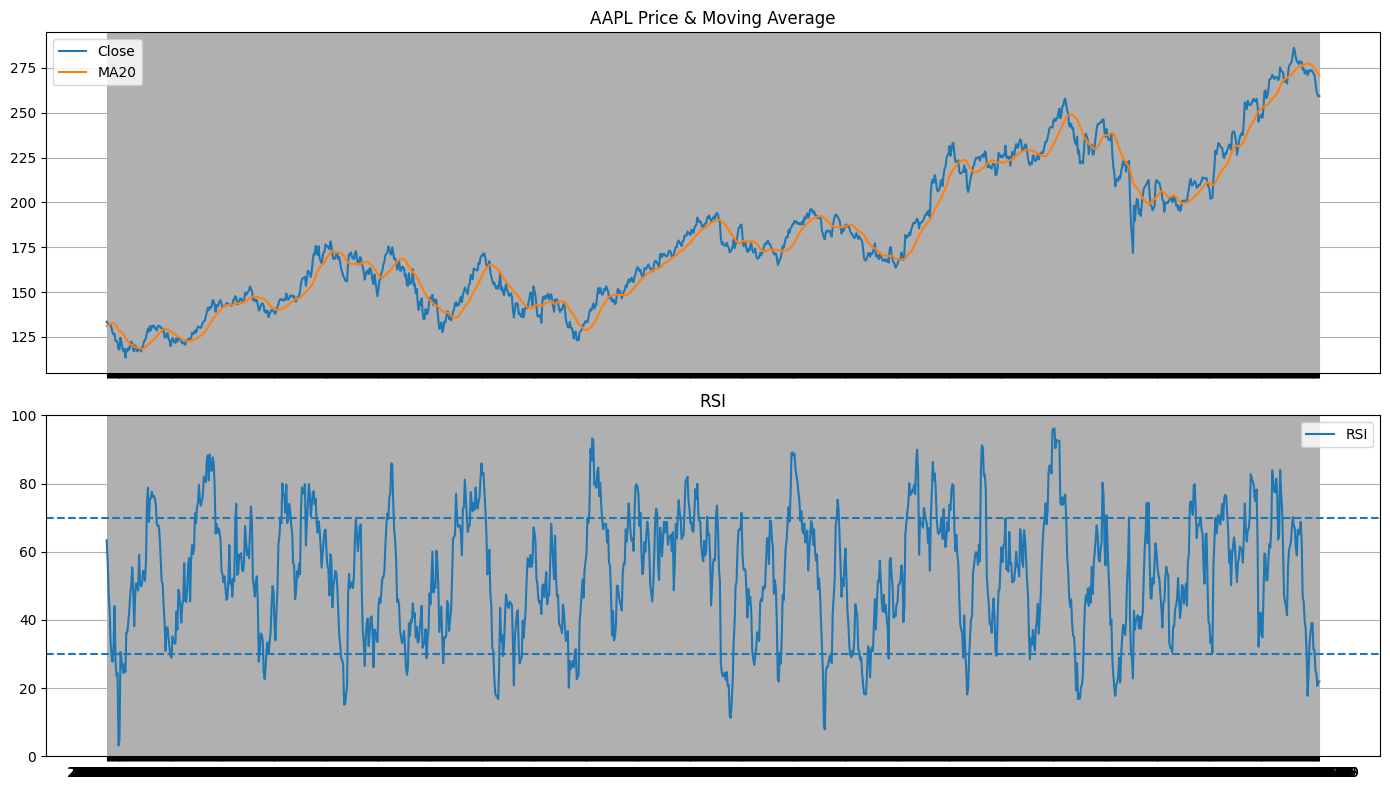

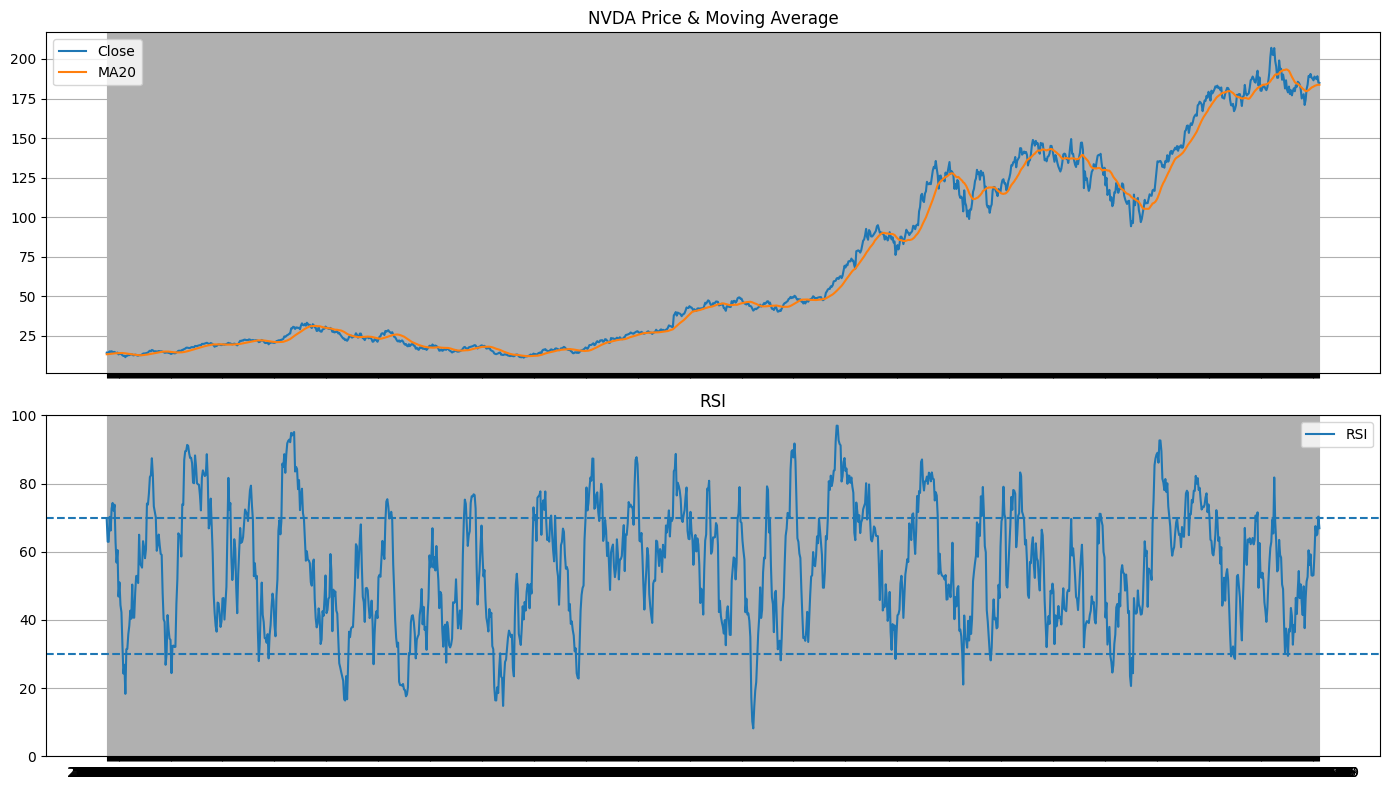

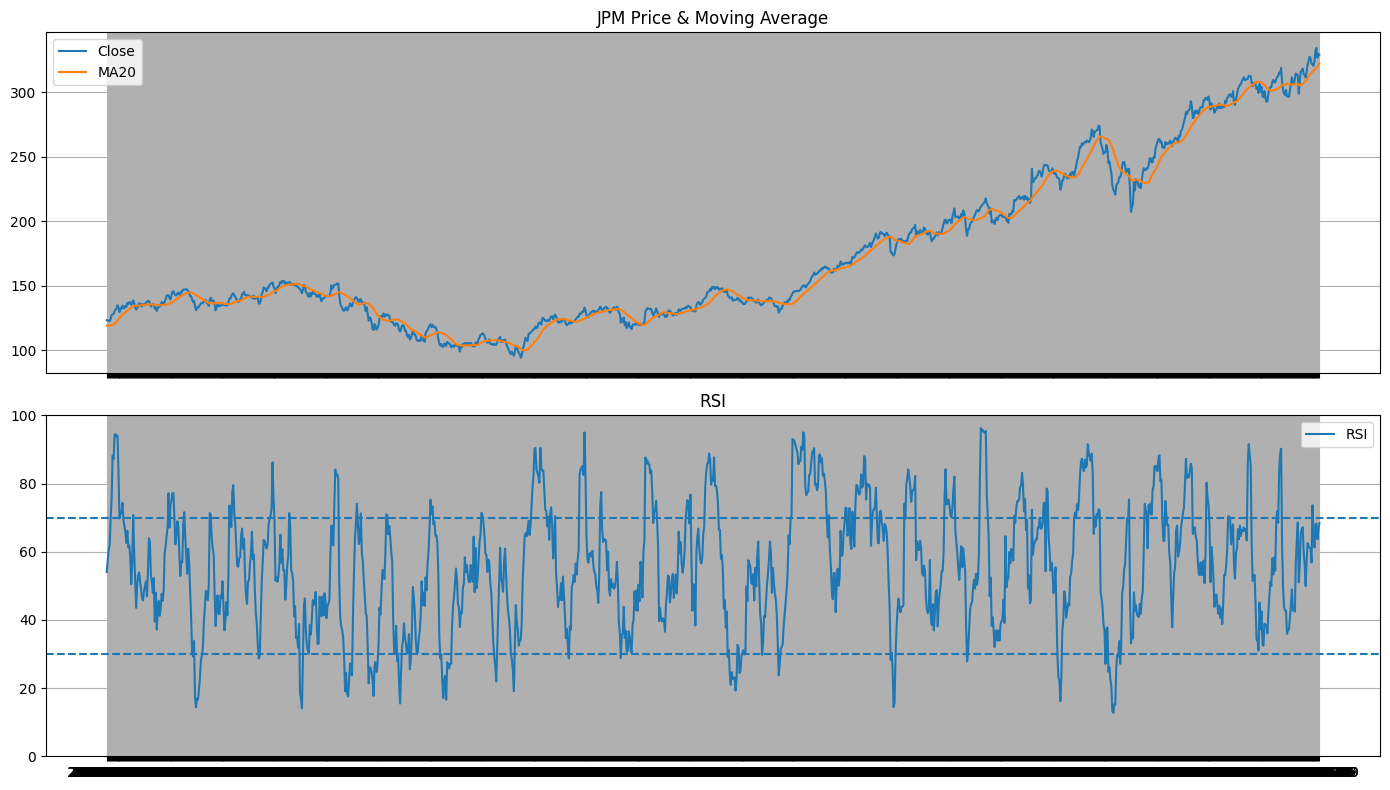

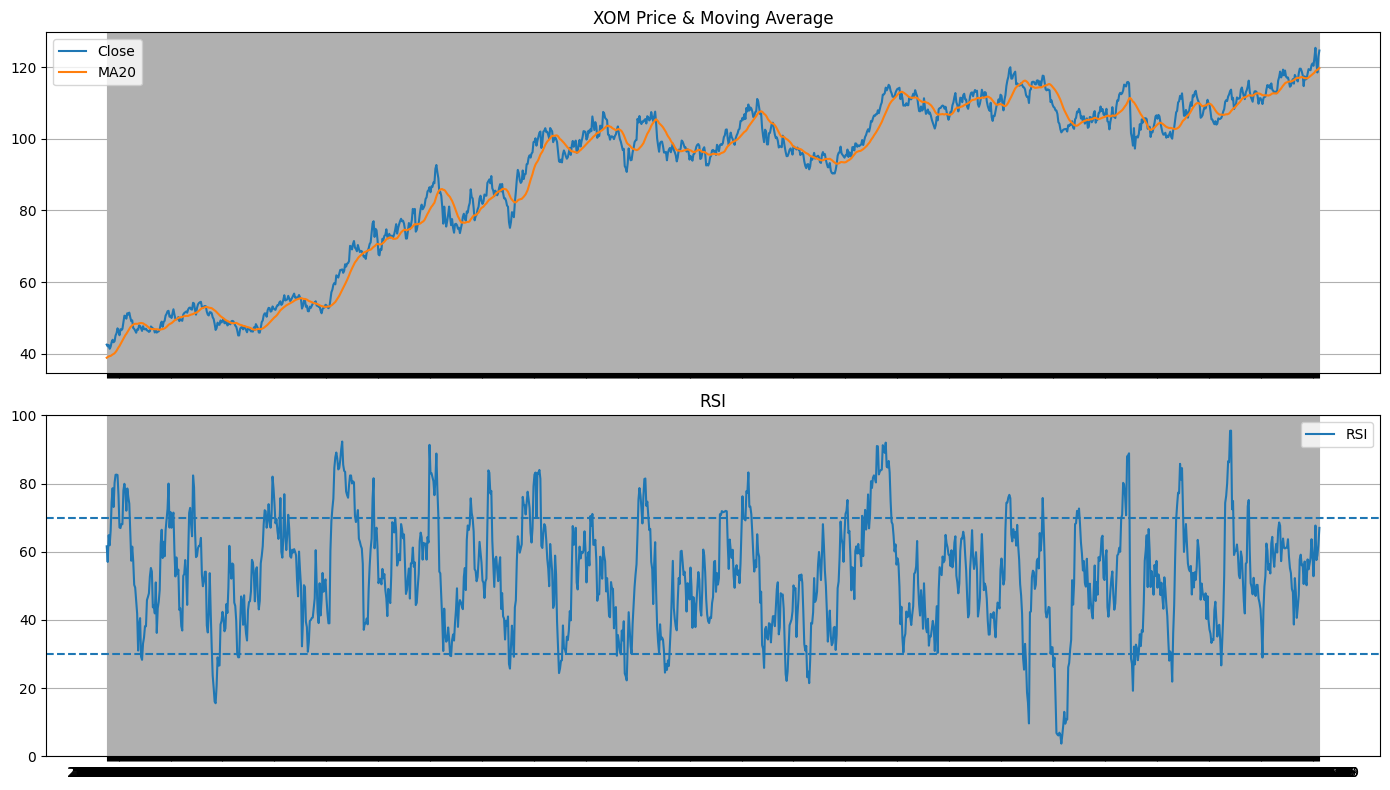

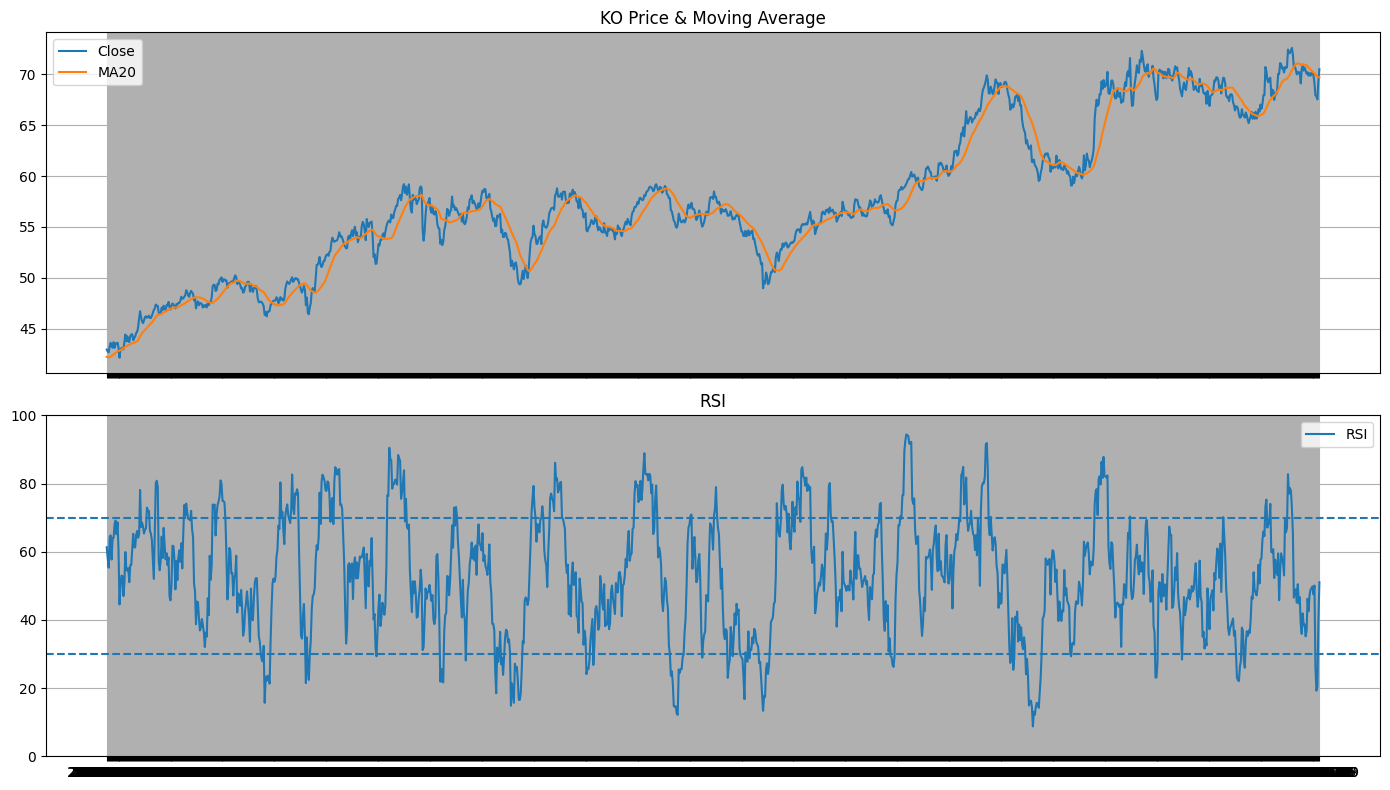

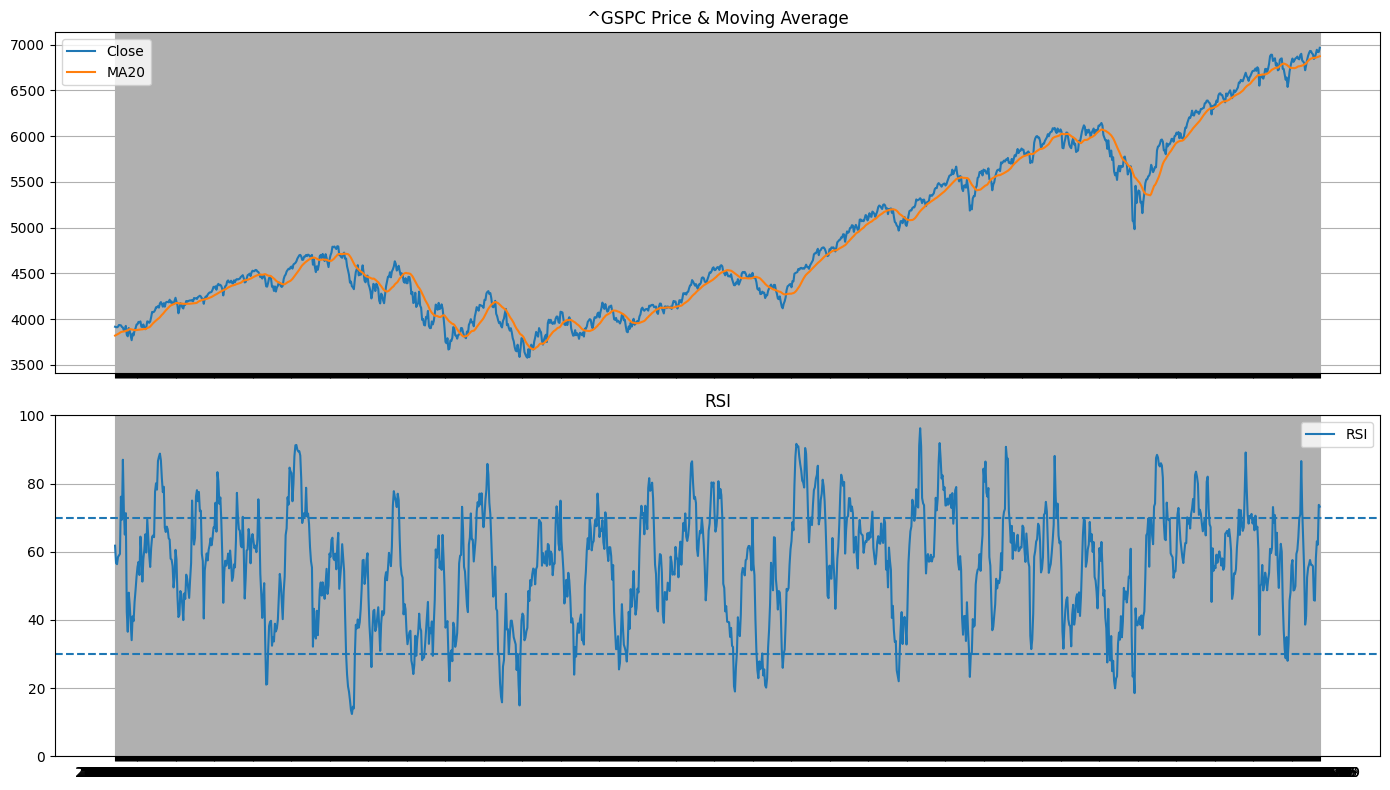

In [5]:
from preprocess import MarketPreprocessor
handler = MarketPreprocessor(window_size=60)
for ticker in tickers:
    df = pd.read_csv(f'data/{ticker}_historical.csv', index_col=0)

    # ---- Handle MultiIndex properly ----
    if isinstance(df.columns, pd.MultiIndex):
        if 'Close' not in df.columns.get_level_values(0):
            print(f"'Close' not found for {ticker}")
            continue

        # ⬇️ Extract SERIES, not DataFrame
        close_series = df.xs('Close', axis=1, level=0).iloc[:, 0]

    else:
        if 'Close' not in df.columns:
            print(f"'Close' not found for {ticker}")
            continue

        close_series = df['Close']

    # ---- Force numeric BEFORE preprocessing ----
    close_series = pd.to_numeric(close_series, errors='coerce')

    # ---- Rebuild clean DataFrame ----
    close_df = pd.DataFrame({'Close': close_series})

    # ---- Now this is 100% safe ----
    df_processed = handler.get_technical_indicators(close_df)

    plot_indicators(df_processed, ticker)
